In [104]:
%load_ext autoreload

# Enable autoreload for all modules
%autoreload 2

import sys
sys.path.append("..")

from loader import data_loader
import numpy as np 
import matplotlib.pyplot as plt
import torch

from graph_plotting import graph_2D
from torch_geometric.data import Dataset
from loader import custom_loader


from sklearn.metrics import accuracy_score, balanced_accuracy_score
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool
from models import graph_classifier, gnn_models
from torch_geometric.loader import DataLoader


from evaluation import evaluation
from graph_plotting import graph_2D


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
octa_dr_dict = {"Healthy": 0, "DM": 0, "PDR": 1, "Early NPDR": 1, "Late NPDR": 1}

HeteroDataLoader = data_loader.HeteroGraphLoaderTorch("/media/data/alex_johannes/octa_data/Cairo/SCP_vessel_graph",
                                                        "/media/data/alex_johannes/octa_data/Cairo/SCP_void_graph",
                                                        "/media/data/alex_johannes/octa_data/Cairo/SCP_heter_edges",
                                                        label_file = "/media/data/alex_johannes/octa_data/Cairo/labels.csv", 
                                                        line_graph_1 =True, 
                                                        class_dict = octa_dr_dict)

no label for  0009_OD
no label for  0288_OD
no label for  0414_OD
no label for  0505_OD
no label for  0505_OS
no label for  0631_OD
no label for  0009_OD
no label for  0288_OD


In [124]:
for key, data in HeteroDataLoader.hetero_graphs.items():
    # check if the .x and .edge_index contains nan values
    for key, val in data.x_dict.items():
        if torch.any(torch.isnan(val)):
            print("nan values in x")
            nan_pos = torch.where(torch.isnan(val))
            val[nan_pos] = 0
        if torch.any(torch.isinf(val)):
            #print("inf values in x")
            # find position of inf values and replace inf by 0
            inf_pos = torch.where(torch.isinf(val))
            val[inf_pos] = 0
    for key, val in data.edge_index_dict.items():
        if torch.any(torch.isnan(val)):
            print("nan values in edge_index")

0002_OS


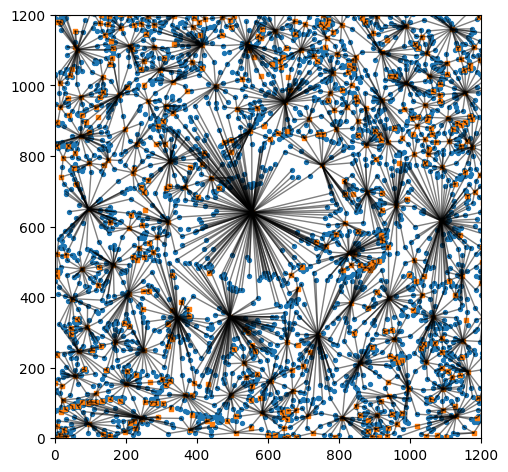

In [125]:
ct = 0
lim = 0
for key, data in HeteroDataLoader.hetero_graphs.items():
    ct +=1
    print(key)
    graph_2D.HeteroGraphPlotter2D().plot_graph_2D(data)
    if ct>lim:
        break
    plt.show()


In [126]:
np.random.seed(0)

work_data = list(HeteroDataLoader.hetero_graphs.values())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_mask = np.random.choice(np.arange(0, len(work_data)), size= int(len(work_data)*0.8), replace = False)
test_mask = np.delete(np.arange(0, len(work_data)), train_mask)

train_list_bin = []
test_list_bin = []


for i, data in enumerate(work_data):
    if i in train_mask:
        train_list_bin.append(data.clone().to(device))
    else:
        test_list_bin.append(data.clone().to(device))


In [127]:
print(np.unique([data.y.clone().cpu() for data in train_list_bin], return_counts=True)[1]/len(train_list_bin))
print(np.unique([data.y.clone().cpu() for data in test_list_bin], return_counts=True)[1]/len(test_list_bin))

[0.73648649 0.26351351]
[0.76785714 0.23214286]


Epoch: 001, Loss: 1.697383, Train Acc: 0.6779, Test Acc: 0.6250, Test Bal Acc: 0.6351
Epoch: 002, Loss: 0.460276, Train Acc: 0.4437, Test Acc: 0.3839, Test Bal Acc: 0.5988
Epoch: 003, Loss: 0.317553, Train Acc: 0.4572, Test Acc: 0.3929, Test Bal Acc: 0.6047
Epoch: 004, Loss: 0.347247, Train Acc: 0.7523, Test Acc: 0.8125, Test Bal Acc: 0.6901
Epoch: 005, Loss: 0.132160, Train Acc: 0.5068, Test Acc: 0.4196, Test Bal Acc: 0.6087
Epoch: 006, Loss: 0.104991, Train Acc: 0.7658, Test Acc: 0.7143, Test Bal Acc: 0.6395
Epoch: 007, Loss: 0.111254, Train Acc: 0.5068, Test Acc: 0.4375, Test Bal Acc: 0.6203
Epoch: 008, Loss: 0.098728, Train Acc: 0.7320, Test Acc: 0.6696, Test Bal Acc: 0.6775
Epoch: 009, Loss: 0.159017, Train Acc: 0.7725, Test Acc: 0.8036, Test Bal Acc: 0.6574
Epoch: 010, Loss: 0.104175, Train Acc: 0.7545, Test Acc: 0.7946, Test Bal Acc: 0.7455
Epoch: 011, Loss: 0.078781, Train Acc: 0.5338, Test Acc: 0.4554, Test Bal Acc: 0.6319
Epoch: 012, Loss: 0.060869, Train Acc: 0.7703, Test Ac

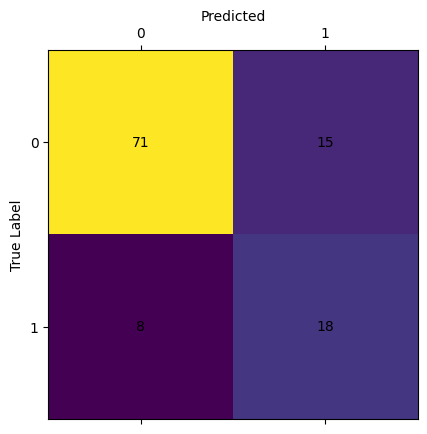

In [190]:
num_classes = 2
epochs = 200
node_types = ["graph_1", "graph_2"] # HeteroDataLoader.hetero_graphs["0002_OS"].node_types

# create the model
model = gnn_models.HeteroGNN(hidden_channels = 32, 
                          out_channels= num_classes, 
                          num_layers= 3, 
                          dropout = 0.1, 
                          aggregation_mode= global_add_pool,
                          node_types = node_types,
                          )
# create brach data loaders for training and test set
train_loader = DataLoader(train_list_bin, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_list_bin, batch_size = 1, shuffle=False)


# weigthings for imbalanced classes 
train_labels = [lab["y"].cpu() for lab in train_list_bin]
weights = 1/np.unique(train_labels, return_counts= True)[1]
balanced_loss = torch.nn.CrossEntropyLoss(torch.tensor(weights).to(device).float())
unbalanced_loss = torch.nn.CrossEntropyLoss() # use when the training data is already balanced

# trainloader can be anything 
classifier = graph_classifier.graphClassifierHetero(model, train_loader, test_loader, balanced_loss)


for epoch in range(1, epochs+1):
    loss = classifier.train()
    train_acc = classifier.test(train_loader)
    outList, yList = classifier.predict(test_loader)
    #print(outList)
    y_p = np.array([item.argmax().cpu().detach().numpy() for sublist in outList for item in sublist])
    y_t = np.array([item.detach().cpu().numpy() for sublist in yList for item in sublist])
    print(f'Epoch: {epoch:03d}, Loss: {loss:.6f}, Train Acc: {train_acc:.4f}, Test Acc: {accuracy_score(y_t, y_p):.4f}, Test Bal Acc: {balanced_accuracy_score(y_t, y_p):.4f}')

    if balanced_accuracy_score(y_t, y_p) > 0.75:
        fig, ax = plt.subplots()
        evaluation.plot_confusion_matrix(y_t, y_p, [0, 1], ax) # , 3, 4
        plt.show()
        break



In [192]:
print(y_p)
print(y_t)
test_idcs = np.array(list(HeteroDataLoader.hetero_graphs.keys()))[test_mask]
print(test_idcs)
print(test_idcs[y_p != y_t])

[0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0
 0 1 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1 1 1 0 1 1
 0]
[0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 1 0 0 0 1
 0]
['0002_OS' '0011_OD' '0030_OS' '0037_OS' '0061_OS' '0066_OS' '0072_OS'
 '0073_OS' '0079_OD' '0081_OS' '0092_OD' '0099_OS' '0100_OD' '0101_OS'
 '0127_OS' '0132_OS' '0138_OD' '0142_OS' '0144_OD' '0144_OS' '0148_OD'
 '0148_OS' '0170_OD' '0177_OS' '0184_OD' '0191_OD' '0191_OS' '0197_OS'
 '0200_OS' '0215_OD' '0220_OD' '0220_OS' '0226_OS' '0245_OD' '0256_OD'
 '0265_OD' '0271_OD' '0276_OS' '0277_OS' '0283_OS' '0289_OS' '0296_OD'
 '0303_OS' '0308_OS' '0310_OD' '0322_OS' '0353_OS' '0359_OD' '0387_OD'
 '0422_OS' '0423_OD' '0430_OS' '0436_OD' '044

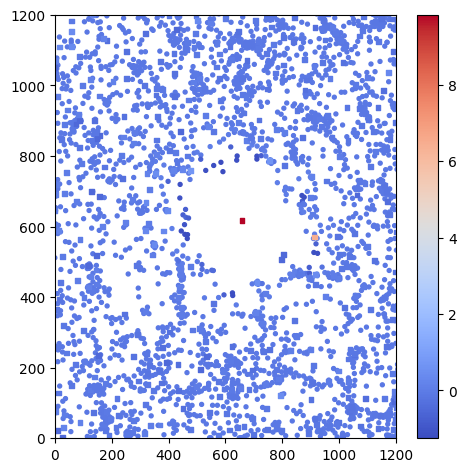

In [191]:
id = "0079_OD"
# now 
eval_data = HeteroDataLoader.hetero_graphs[id].clone().to(device)
pred_val = model.vals_without_aggregation(eval_data.x_dict,eval_data.edge_index_dict)
graph_2D.HeteroGraphPlotter2D().plot_graph_2D(HeteroDataLoader.hetero_graphs[id], pred_val_dict=pred_val, edges=False)

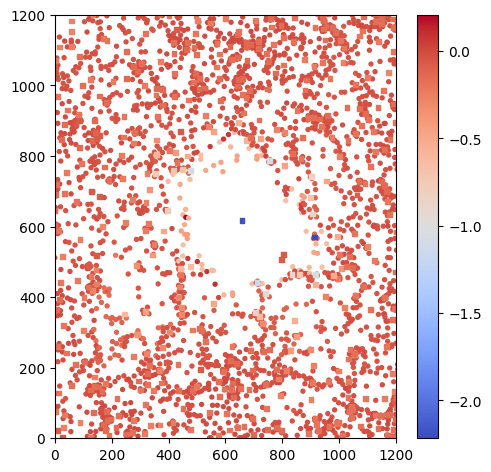

In [187]:
id = "0079_OD"
# now 
eval_data = HeteroDataLoader.hetero_graphs[id].clone().to(device)
pred_val = model.vals_without_aggregation(eval_data.x_dict,eval_data.edge_index_dict)
graph_2D.HeteroGraphPlotter2D().plot_graph_2D(HeteroDataLoader.hetero_graphs[id], pred_val_dict=pred_val, edges=False)

In [18]:
for key, data in HeteroDataLoader.line_graphs_1.items():
    # check if the .x and .edge_index contains nan values
    if torch.any(torch.isnan(data.x)):
        nan_pos = torch.where(torch.isnan(data.x))
        data.x[nan_pos] = 0
        print("nan values in x")
    if torch.any(torch.isinf(data.x)):
        #print("inf values in x")
        # find position of inf values and replace inf by 0
        inf_pos = torch.where(torch.isinf(data.x))
        data.x[inf_pos] = 0

In [19]:
np.random.seed(0)

work_data_line_graphs_1 = list(HeteroDataLoader.line_graphs_1.values())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_mask = np.random.choice(np.arange(0, len(work_data)), size= int(len(work_data)*0.8), replace = False)
test_mask = np.delete(np.arange(0, len(work_data)), train_mask)

train_list_bin_line_graphs_1 = []
test_list_bin_line_graphs_1 = []

for i, data in enumerate(work_data_line_graphs_1):
    if i in train_mask:
        train_list_bin_line_graphs_1.append(data.clone().to(device))
    else:
        test_list_bin_line_graphs_1.append(data.clone().to(device))

In [21]:
# selection of the features to use
num_features = train_list_bin_line_graphs_1[0].x.shape[1]
num_classes = 2
epochs = 50

# create the model
model = gnn_models.GNN(in_channels= num_features, hidden_channels = 64, out_channels= num_classes, num_layers= 5, dropout = 0.2, aggregation_mode= global_mean_pool)

# create brach data loaders for training and test set
train_loader_line_graphs_1 = DataLoader(train_list_bin_line_graphs_1, batch_size = 32, shuffle=True)
test_loader_line_graphs_1 = DataLoader(test_list_bin_line_graphs_1, batch_size = 1, shuffle=False)

# weigthings for imbalanced classes 
train_labels_line_graphs_1 = [lab["y"].cpu() for lab in train_list_bin_line_graphs_1]
weights = 1/np.unique(train_labels_line_graphs_1, return_counts= True)[1]
balanced_loss = torch.nn.CrossEntropyLoss(torch.tensor(weights).to(device).float())
unbalanced_loss = torch.nn.CrossEntropyLoss() # use when the training data is already balanced

# trainloader can be anything 
classifier = graph_classifier.graphClassifierClassic(model, train_loader_line_graphs_1, test_loader_line_graphs_1, balanced_loss)


for epoch in range(1, epochs+1):
    loss = classifier.train()
    train_acc = classifier.test(train_loader_line_graphs_1)
    #test_acc = classifier.test(test_loader_line_graphs_1)
    outList, yList = classifier.predict(test_loader_line_graphs_1)
    y_p = np.array([item.argmax().cpu().detach().numpy() for sublist in outList for item in sublist])
    y_t = np.array([item.detach().cpu().numpy() for sublist in yList for item in sublist])
    print(f'Epoch: {epoch:03d}, Loss: {loss:.6f}, Train Acc: {train_acc:.4f}, Test Acc: {accuracy_score(y_t, y_p):.4f}, Test Bal Acc: {balanced_accuracy_score(y_t, y_p):.4f}')


fig, ax = plt.subplots()
evaluation.plot_confusion_matrix(y_t, y_p, [0, 1, 2], ax)

Epoch: 001, Loss: 0.023446, Train Acc: 0.3401, Test Acc: 0.2957, Test Bal Acc: 0.5422
Epoch: 002, Loss: 0.021863, Train Acc: 0.4212, Test Acc: 0.3907, Test Bal Acc: 0.5959
Epoch: 003, Loss: 0.021718, Train Acc: 0.7815, Test Acc: 0.7447, Test Bal Acc: 0.7057
Epoch: 004, Loss: 0.021599, Train Acc: 0.7545, Test Acc: 0.7755, Test Bal Acc: 0.5000


KeyboardInterrupt: 

In [33]:
np.random.seed(0)

work_data_full_graphs_2 = list(HeteroDataLoader.full_graphs_2.values())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_mask = np.random.choice(np.arange(0, len(work_data)), size= int(len(work_data)*0.8), replace = False)
test_mask = np.delete(np.arange(0, len(work_data)), train_mask)

train_list_bin_full_graphs_2 = []
test_list_bin_full_graphs_2 = []

for i, data in enumerate(work_data_full_graphs_2):
    if i in train_mask:
        train_list_bin_full_graphs_2.append(data.clone().to(device))
    else:
        test_list_bin_full_graphs_2.append(data.clone().to(device))

Epoch: 001, Loss: 1.738850, Train Acc: 0.2635, Test Acc: 0.2321, Test Bal Acc: 0.5000
Epoch: 002, Loss: 0.795939, Train Acc: 0.6982, Test Acc: 0.7143, Test Bal Acc: 0.6261
Epoch: 003, Loss: 0.485097, Train Acc: 0.7297, Test Acc: 0.7679, Test Bal Acc: 0.5000
Epoch: 004, Loss: 0.290332, Train Acc: 0.6689, Test Acc: 0.5982, Test Bal Acc: 0.5908
Epoch: 005, Loss: 0.250603, Train Acc: 0.7365, Test Acc: 0.7679, Test Bal Acc: 0.5000
Epoch: 006, Loss: 0.220160, Train Acc: 0.7523, Test Acc: 0.7500, Test Bal Acc: 0.5286
Epoch: 007, Loss: 0.222723, Train Acc: 0.7365, Test Acc: 0.7321, Test Bal Acc: 0.5707
Epoch: 008, Loss: 0.177549, Train Acc: 0.7432, Test Acc: 0.7411, Test Bal Acc: 0.4826
Epoch: 009, Loss: 0.146013, Train Acc: 0.6869, Test Acc: 0.6607, Test Bal Acc: 0.6717
Epoch: 010, Loss: 0.128883, Train Acc: 0.7500, Test Acc: 0.7411, Test Bal Acc: 0.5094
Epoch: 011, Loss: 0.145037, Train Acc: 0.7230, Test Acc: 0.6875, Test Bal Acc: 0.6355
Epoch: 012, Loss: 0.113561, Train Acc: 0.7455, Test Ac

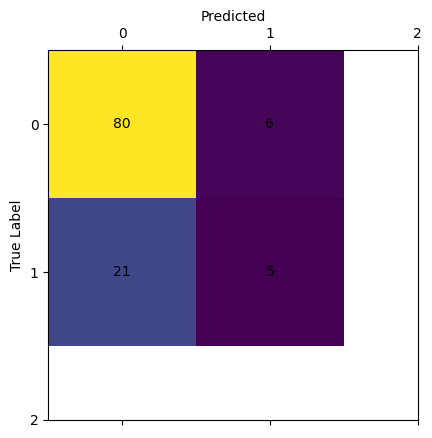

In [34]:
# selection of the features to use
num_features = train_list_bin_full_graphs_2[0].x.shape[1]
num_classes = 2
epochs = 50

# create the model
model = gnn_models.GNN(in_channels= num_features, hidden_channels = 64, out_channels= num_classes, num_layers= 5, dropout = 0.2, aggregation_mode= global_mean_pool)

# create brach data loaders for training and test set
train_loader_full_graphs_2 = DataLoader(train_list_bin_full_graphs_2, batch_size = 32, shuffle=True)
test_loader_full_graphs_2 = DataLoader(test_list_bin_full_graphs_2, batch_size = 1, shuffle=False)

# weigthings for imbalanced classes 
train_labels_full_graphs_2 = [lab["y"].cpu() for lab in train_list_bin_full_graphs_2]
weights = 1/np.unique(train_labels_full_graphs_2, return_counts= True)[1]
balanced_loss = torch.nn.CrossEntropyLoss(torch.tensor(weights).to(device).float())
unbalanced_loss = torch.nn.CrossEntropyLoss() # use when the training data is already balanced

# trainloader can be anything 
classifier = graph_classifier.graphClassifierClassic(model, train_loader_full_graphs_2, test_loader_full_graphs_2, balanced_loss)


for epoch in range(1, epochs+1):
    loss = classifier.train()
    train_acc = classifier.test(train_loader_full_graphs_2)
    #test_acc = classifier.test(test_loader_full_graphs_2)
    outList, yList = classifier.predict(test_loader_full_graphs_2)
    y_p = np.array([item.argmax().cpu().detach().numpy() for sublist in outList for item in sublist])
    y_t = np.array([item.detach().cpu().numpy() for sublist in yList for item in sublist])
    print(f'Epoch: {epoch:03d}, Loss: {loss:.6f}, Train Acc: {train_acc:.4f}, Test Acc: {accuracy_score(y_t, y_p):.4f}, Test Bal Acc: {balanced_accuracy_score(y_t, y_p):.4f}')


fig, ax = plt.subplots()
evaluation.plot_confusion_matrix(y_t, y_p, [0, 1], ax)